In [14]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
import os

In [15]:
def load_and_analyze(filepath):
    #Initial print
    print(f"\n{'='*30}")
    print(f"Analyzing: {os.path.basename(filepath)}")
    print('='*30)

    # Mesh loading
    mesh = trimesh.load(filepath)
    vertices = np.array(mesh.vertices)  
    faces = np.array(mesh.faces)
        
    num_vertices = vertices.shape[0]
    num_faces = faces.shape[0]
    
    print(f"Number of vertices: {num_vertices}")
    print(f"Number of faces: {num_faces}")
    
    #per-axis statistics
    axis_names = np.array(['X', 'Y', 'Z'])
    mins = np.min(vertices, axis=0)
    maxs = np.max(vertices, axis=0)
    means = np.mean(vertices, axis=0)
    stds = np.std(vertices, axis=0)
        
    for i, axis in enumerate(axis_names):
        print(f"\n{axis}-axis:")
        print(f"  Min: {mins[i]:.4f}")
        print(f"  Max: {maxs[i]:.4f}")
        print(f"  Mean: {means[i]:.4f}")
        print(f"  Std Dev: {stds[i]:.4f}")
    
    # Additional analysis
    print(f"\nBounding box dimensions:")
    bbox_dims = maxs - mins
    print(f"Width (X): {bbox_dims[0]:.4f}")
    print(f"Depth (Y): {bbox_dims[1]:.4f}")
    print(f"Height (Z): {bbox_dims[2]:.4f}")
    
    print(f"\nMesh centroid: ({means[0]:.4f}, {means[1]:.4f}, {means[2]:.4f})")
    
    # Visualization                                
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces, cmap='viridis', alpha=0.8, edgecolor='none')
    
    ax.set_title(f'{os.path.basename(filepath)}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.tight_layout()
    plt.show()
    
    return mesh, vertices

In [16]:
meshes = "meshes/"
mesh_samples = np.array([i for i in os.listdir(meshes) if i.endswith('.obj')])

print(f"Found {len(mesh_samples)} sample mesh files")

Found 8 sample mesh files



Analyzing: branch.obj
Number of vertices: 2767
Number of faces: 1960

X-axis:
  Min: -0.8516
  Max: 0.8496
  Mean: 0.0754
  Std Dev: 0.3434

Y-axis:
  Min: 0.0000
  Max: 1.9004
  Mean: 1.0874
  Std Dev: 0.4570

Z-axis:
  Min: -0.4648
  Max: 0.4629
  Mean: 0.1220
  Std Dev: 0.2001

Bounding box dimensions:
Width (X): 1.7012
Depth (Y): 1.9004
Height (Z): 0.9277

Mesh centroid: (0.0754, 1.0874, 0.1220)


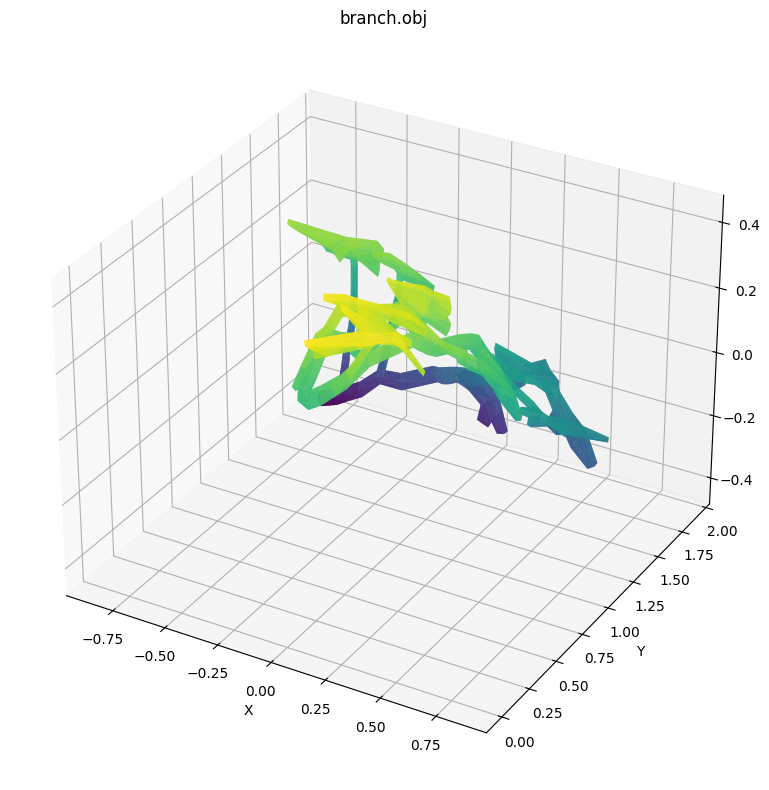


Analyzing: cylinder.obj
Number of vertices: 192
Number of faces: 124

X-axis:
  Min: -1.0000
  Max: 1.0000
  Mean: -0.0000
  Std Dev: 0.7071

Y-axis:
  Min: -1.0000
  Max: 1.0000
  Mean: 0.0000
  Std Dev: 1.0000

Z-axis:
  Min: -1.0000
  Max: 1.0000
  Mean: 0.0000
  Std Dev: 0.7071

Bounding box dimensions:
Width (X): 2.0000
Depth (Y): 2.0000
Height (Z): 2.0000

Mesh centroid: (-0.0000, 0.0000, 0.0000)


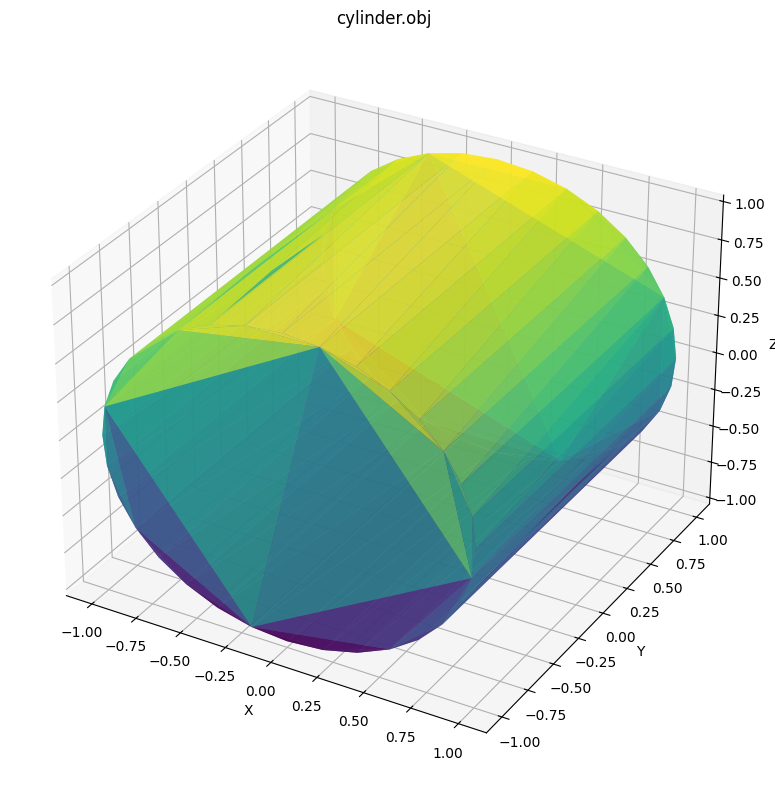


Analyzing: explosive.obj
Number of vertices: 2812
Number of faces: 2566

X-axis:
  Min: -0.1996
  Max: 0.1996
  Mean: 0.0429
  Std Dev: 0.1151

Y-axis:
  Min: -0.0000
  Max: 1.0000
  Mean: 0.5291
  Std Dev: 0.3899

Z-axis:
  Min: -0.1971
  Max: 0.1971
  Mean: -0.0034
  Std Dev: 0.0947

Bounding box dimensions:
Width (X): 0.3992
Depth (Y): 1.0000
Height (Z): 0.3943

Mesh centroid: (0.0429, 0.5291, -0.0034)


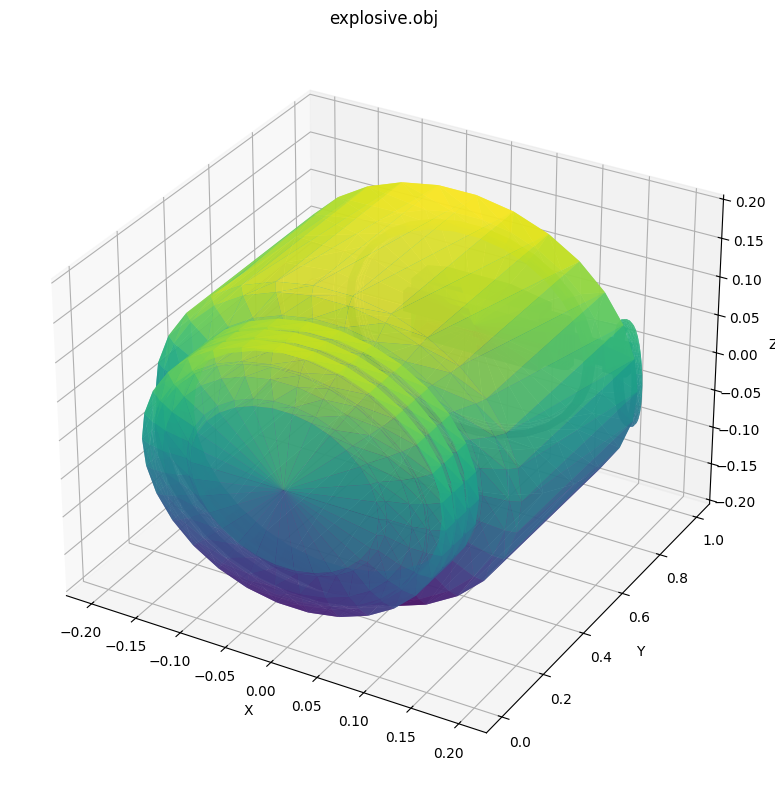


Analyzing: fence.obj
Number of vertices: 1088
Number of faces: 684

X-axis:
  Min: -0.5000
  Max: 0.5000
  Mean: -0.0035
  Std Dev: 0.3458

Y-axis:
  Min: 0.0000
  Max: 0.8432
  Mean: 0.4105
  Std Dev: 0.2540

Z-axis:
  Min: -0.0225
  Max: 0.0225
  Mean: -0.0004
  Std Dev: 0.0110

Bounding box dimensions:
Width (X): 1.0000
Depth (Y): 0.8432
Height (Z): 0.0450

Mesh centroid: (-0.0035, 0.4105, -0.0004)


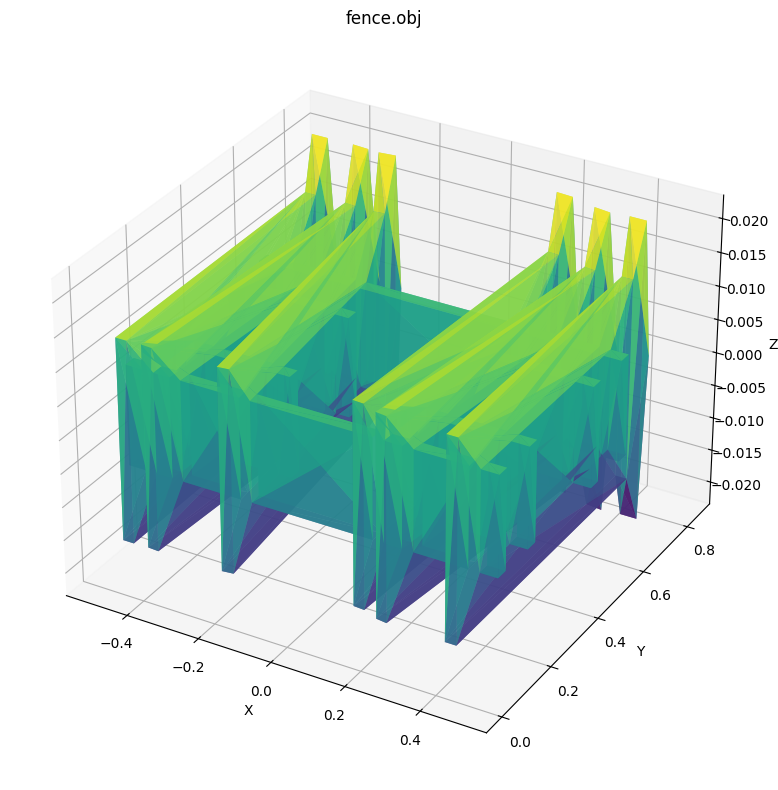


Analyzing: girl.obj
Number of vertices: 8284
Number of faces: 8475

X-axis:
  Min: -0.5000
  Max: 0.5000
  Mean: 0.0021
  Std Dev: 0.1788

Y-axis:
  Min: 0.0000
  Max: 0.9044
  Mean: 0.4034
  Std Dev: 0.2144

Z-axis:
  Min: -0.1814
  Max: 0.1814
  Mean: 0.0140
  Std Dev: 0.0618

Bounding box dimensions:
Width (X): 1.0000
Depth (Y): 0.9044
Height (Z): 0.3628

Mesh centroid: (0.0021, 0.4034, 0.0140)


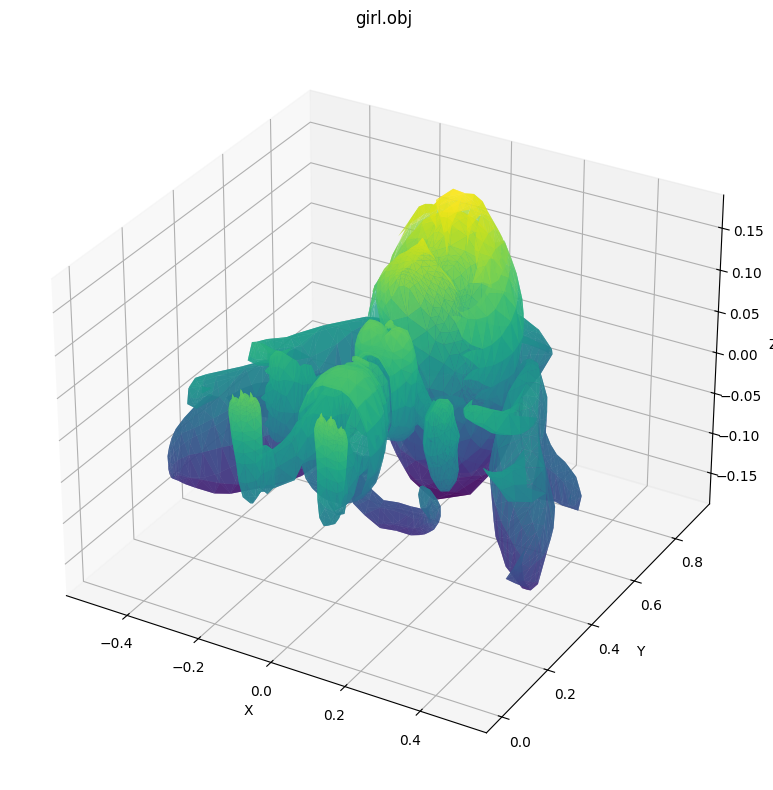


Analyzing: person.obj
Number of vertices: 3103
Number of faces: 2251

X-axis:
  Min: -0.8438
  Max: 0.8418
  Mean: 0.0049
  Std Dev: 0.3951

Y-axis:
  Min: -0.0000
  Max: 1.9004
  Mean: 1.1595
  Std Dev: 0.5119

Z-axis:
  Min: -0.2129
  Max: 0.2109
  Mean: -0.0036
  Std Dev: 0.0951

Bounding box dimensions:
Width (X): 1.6855
Depth (Y): 1.9004
Height (Z): 0.4238

Mesh centroid: (0.0049, 1.1595, -0.0036)


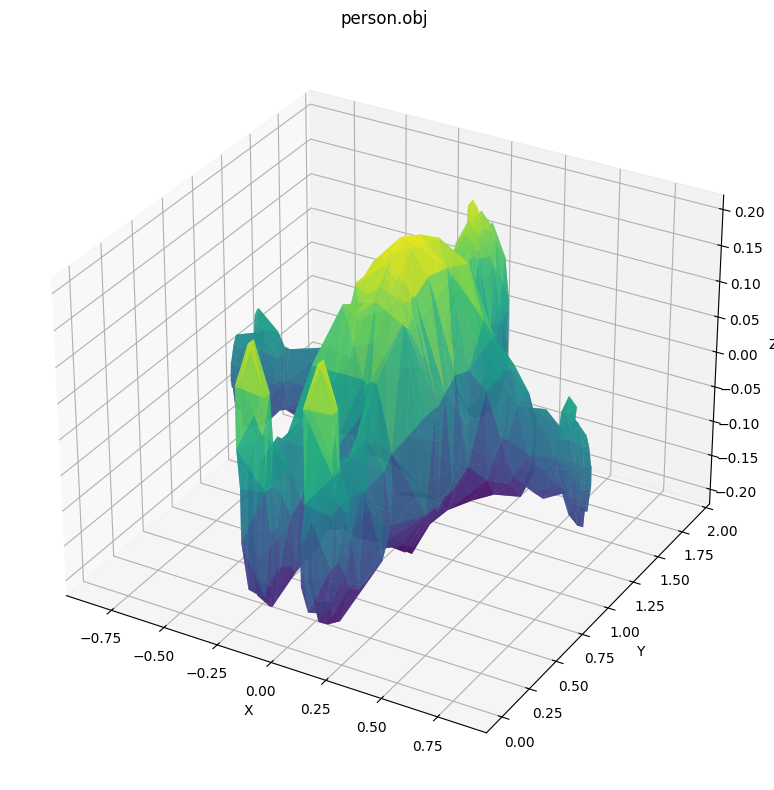


Analyzing: table.obj
Number of vertices: 3148
Number of faces: 4100

X-axis:
  Min: -0.2089
  Max: 0.2089
  Mean: -0.0132
  Std Dev: 0.1531

Y-axis:
  Min: 0.0000
  Max: 0.6118
  Mean: 0.3864
  Std Dev: 0.1919

Z-axis:
  Min: -0.5000
  Max: 0.5000
  Mean: -0.0036
  Std Dev: 0.3461

Bounding box dimensions:
Width (X): 0.4178
Depth (Y): 0.6118
Height (Z): 1.0000

Mesh centroid: (-0.0132, 0.3864, -0.0036)


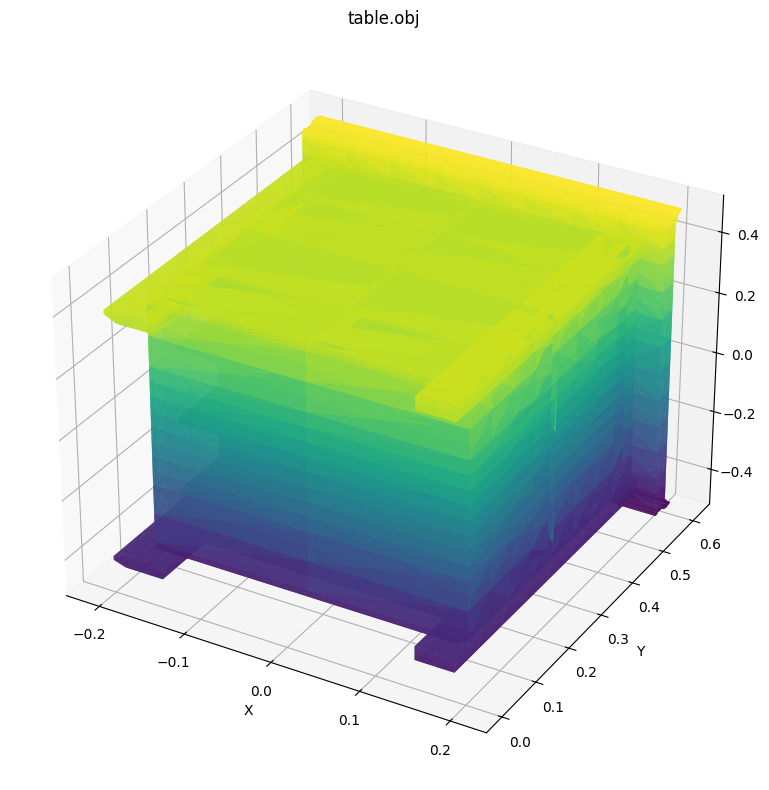


Analyzing: talwar.obj
Number of vertices: 1668
Number of faces: 1922

X-axis:
  Min: -0.0319
  Max: 0.0319
  Mean: 0.0217
  Std Dev: 0.0112

Y-axis:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.3028
  Std Dev: 0.2369

Z-axis:
  Min: -0.1171
  Max: 0.1171
  Mean: -0.0044
  Std Dev: 0.0468

Bounding box dimensions:
Width (X): 0.0638
Depth (Y): 1.0000
Height (Z): 0.2343

Mesh centroid: (0.0217, 0.3028, -0.0044)


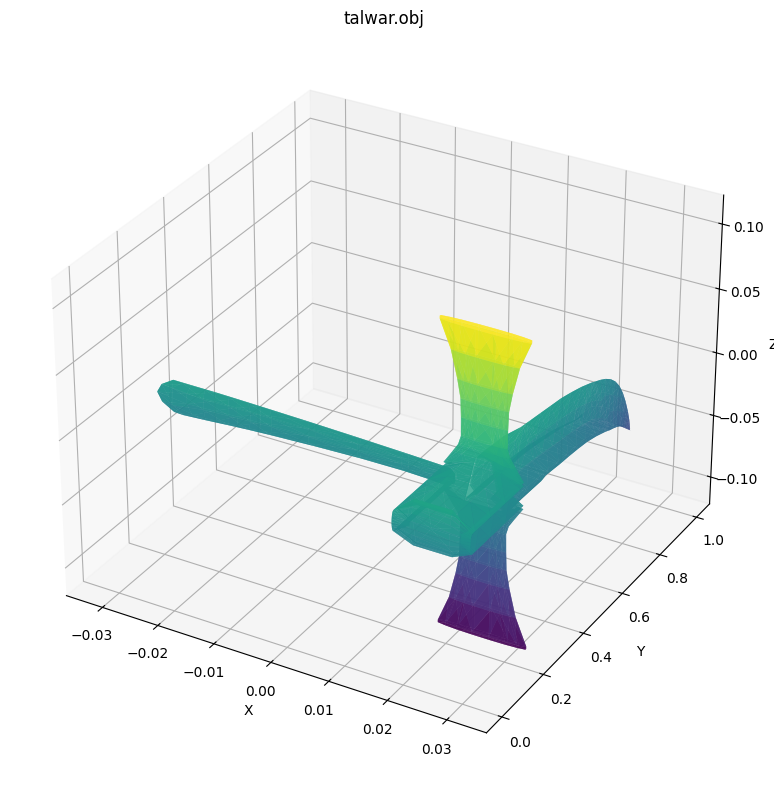

In [17]:
for sample_filename in mesh_samples:
    filepath = os.path.join(meshes, sample_filename)
    mesh, vertices = load_and_analyze(filepath)

In [18]:
BINS = 1024
OUTPUT_ROOT = "Outputs"
MESH_DIR = "meshes"

In [19]:
def minmax_normalize(vertices):
    """
    Min–Max Normalization: Scale vertex coordinates into [0, 1] per axis.
    """
    v_min = vertices.min(axis=0)
    v_max = vertices.max(axis=0)
    # prevent divide-by-zero
    range_ = v_max - v_min
    range_[range_ == 0] = 1.0
    normalized = (vertices - v_min) / range_
    return normalized, v_min, v_max

def unit_sphere_normalize(vertices):
    """
    Unit Sphere Normalization: Center vertices and scale so that 
    the farthest vertex lies on a unit sphere (‖v‖ ≤ 1).
    """
    centroid = vertices.mean(axis=0)
    centered = vertices - centroid
    scale = np.max(np.linalg.norm(centered, axis=1))
    if scale == 0: 
        scale = 1.0
    normalized = centered / scale
    return normalized, centroid, scale

In [20]:
def quantize(normalized, bins=1024):
    """
    Discretize normalized coordinates into bins.
    If normalization range is [-1, 1], first map to [0, 1].
    """
    norm_copy = normalized.copy()
    if norm_copy.min() < 0:
        norm_copy = (norm_copy + 1) / 2  # shift [-1,1] → [0,1]
    norm_copy = np.clip(norm_copy, 0, 1)
    quantized = np.floor(norm_copy * (bins - 1)).astype(np.int32)
    return quantized




In [ ]:
def visualize_task2(norm_mm, norm_us, quant_mm, quant_us, faces, sample_name, sample_dir):
    """
    Generateing a 2×2 subplot for each mesh:
    Row 1: Min–Max Normalized | Unit Sphere Normalized
    Row 2: Min–Max Quantized  | Unit Sphere Quantized
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np, os

    # #Downsample for speed
    # def maybe_downsample(verts, max_verts=8000):
    #     if len(verts) > max_verts:
    #         idx = np.random.choice(len(verts), max_verts, replace=False)
    #         return verts[idx]
    #     return verts
    """ Removed the downsampling function and passing the values as it is."""
    norm_mm_vis = norm_mm
    norm_us_vis = norm_us
    quant_mm_vis =quant_mm.astype(float)
    quant_us_vis =quant_us.astype(float)

    # --- Create figure ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 12), subplot_kw={'projection': '3d'})
    fig.suptitle(f'Task 2 Results: {sample_name}', fontsize=15, fontweight='bold')

    
    def set_equal_axes(ax, data):
        mins, maxs = data.min(axis=0), data.max(axis=0)
        rng = maxs - mins
        mid = (maxs + mins) / 2
        max_range = rng.max() / 2
        ax.set_xlim(mid[0]-max_range, mid[0]+max_range)
        ax.set_ylim(mid[1]-max_range, mid[1]+max_range)
        ax.set_zlim(mid[2]-max_range, mid[2]+max_range)

  
    plots = [
        (axs[0,0], norm_mm_vis, 'Min–Max Normalized', 'skyblue'),
        (axs[0,1], norm_us_vis, 'Unit Sphere Normalized', 'lightgreen'),
        (axs[1,0], quant_mm_vis, 'Min–Max Quantized', 'orange'),
        (axs[1,1], quant_us_vis, 'Unit Sphere Quantized', 'pink')
    ]

    for ax, data, title, color in plots:
        ax.scatter(data[:,0], data[:,1], data[:,2], s=5, c=color, alpha=0.7)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        set_equal_axes(ax, data)
        ax.grid(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

 
    plot_path = os.path.join(sample_dir, "plots", "task2_results.png")
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

    print(f"Visualization saved {plot_path}")


In [22]:
def process_mesh_task2(mesh_path, sample_name):
    """
    Process a single mesh for Task 2:
    1. Load mesh
    2. Apply both normalization methods
    3. Quantize both
    4. Save all four meshes (.ply)
    5. Generate visualization
    """
    print(f"\n{'='*60}")
    print(f"Processing: {sample_name}")
    print(f"{'='*60}")
    
    # Load mesh
    mesh = trimesh.load(mesh_path, process=False)
    vertices = np.array(mesh.vertices)
    faces = np.array(mesh.faces)
    
    print(f"Vertices: {len(vertices)}, Faces: {len(faces)}")
    
    # Apply both normalization methods
    print("\n[1] Normalizing...")
    norm_mm, vmin, vmax = minmax_normalize(vertices)
    norm_us, centroid, scale = unit_sphere_normalize(vertices)
    print(f" Min–Max range: [{norm_mm.min():.3f}, {norm_mm.max():.3f}]")
    print(f" Unit Sphere range: [{norm_us.min():.3f}, {norm_us.max():.3f}]")
    
    # Quantize both
    print(f"\n[2] Quantizing with {BINS} bins...")
    quant_mm = quantize(norm_mm, bins=BINS)
    quant_us = quantize(norm_us, bins=BINS)
    print(f" Min–Max quantized: [{quant_mm.min()}, {quant_mm.max()}]")
    print(f" Unit Sphere quantized: [{quant_us.min()}, {quant_us.max()}]")
    
    # Create output directories
    sample_dir = os.path.join(OUTPUT_ROOT, sample_name)
    os.makedirs(os.path.join(sample_dir, "normalized"), exist_ok=True)
    os.makedirs(os.path.join(sample_dir, "quantized"), exist_ok=True)
    os.makedirs(os.path.join(sample_dir, "plots"), exist_ok=True)
    
    # Save all four meshes
    print("\n[3] Saving meshes...")
    trimesh.Trimesh(norm_mm, faces, process=False).export(
        os.path.join(sample_dir, "normalized", "minmax.ply"))
    trimesh.Trimesh(norm_us, faces, process=False).export(
        os.path.join(sample_dir, "normalized", "unitsphere.ply"))
    trimesh.Trimesh(quant_mm.astype(float), faces, process=False).export(
        os.path.join(sample_dir, "quantized", "minmax.ply"))
    trimesh.Trimesh(quant_us.astype(float), faces, process=False).export(
        os.path.join(sample_dir, "quantized", "unitsphere.ply"))
    
    print(f"  ✓ Saved normalized meshes: {sample_dir}/normalized/")
    print(f"  ✓ Saved quantized meshes: {sample_dir}/quantized/")
    
    # Generate visualization
    print("\n[4] Creating visualization...")
    visualize_task2(norm_mm, norm_us, quant_mm, quant_us, faces, sample_name, sample_dir)
    
    print(f"\n{'='*60}")
    print(f"Completed: {sample_name}")
    print(f"{'='*60}\n")


In [24]:
def process_all_meshes():
    """
    Loop through all meshes in the dataset and process each for Task 2.
    """
    # Find all .obj files in MESH_DIR
    mesh_files = [f for f in os.listdir(MESH_DIR) if f.endswith('.obj')]
    
    if not mesh_files:
        print(f"No .obj files found in {MESH_DIR}/")
        return
    
    print(f"\n{'='*70}")
    print(f"TASK 2: NORMALIZE & QUANTIZE MESHES")
    print(f"{'='*70}")
    print(f"Found {len(mesh_files)} mesh file(s)")
    print(f"Output directory: {OUTPUT_ROOT}/")
    print(f"Bins: {BINS}")
    
    # Process each mesh
    for mesh_file in mesh_files:
        mesh_path = os.path.join(MESH_DIR, mesh_file)
        sample_name = os.path.splitext(mesh_file)[0]

        
        try:
            process_mesh_task2(mesh_path, sample_name)  
        except Exception as e:
            print(f"\n✗ ERROR processing {mesh_file}: {e}")
            import traceback
            traceback.print_exc()
    
    print(f"\n{'='*70}")
    print(f"TASK 2 COMPLETE")
    print(f"{'='*70}")
    print(f"\n Deliverables for each mesh:")
    print(f"   • normalized/minmax.ply")
    print(f"   • normalized/unitsphere.ply")
    print(f"   • quantized/minmax.ply")
    print(f"   • quantized/unitsphere.ply")
    print(f"   • plots/task2_results.png")
    print(f"\n{'='*70}\n")

In [25]:
if __name__ == "__main__":
    process_all_meshes()


TASK 2: NORMALIZE & QUANTIZE MESHES
Found 8 mesh file(s)
Output directory: Outputs/
Bins: 1024

Processing: branch
Vertices: 2767, Faces: 1960

[1] Normalizing...
 Min–Max range: [0.000, 1.000]
 Unit Sphere range: [-0.805, 0.602]

[2] Quantizing with 1024 bins...
 Min–Max quantized: [0, 1023]
 Unit Sphere quantized: [99, 819]

[3] Saving meshes...
  ✓ Saved normalized meshes: Outputs\branch/normalized/
  ✓ Saved quantized meshes: Outputs\branch/quantized/

[4] Creating visualization...
Visualization saved → Outputs\branch\plots\task2_results.png

Completed: branch


Processing: cylinder
Vertices: 192, Faces: 124

[1] Normalizing...
 Min–Max range: [0.000, 1.000]
 Unit Sphere range: [-0.707, 0.707]

[2] Quantizing with 1024 bins...
 Min–Max quantized: [0, 1023]
 Unit Sphere quantized: [149, 873]

[3] Saving meshes...
  ✓ Saved normalized meshes: Outputs\cylinder/normalized/
  ✓ Saved quantized meshes: Outputs\cylinder/quantized/

[4] Creating visualization...
Visualization saved → Outp

Normalization is done to put the mesh in a common scale so that it can be better processed. The 2 such way to perform normalization on a mesh are as follows:-

1. Min-max Normalization

In Min-max we take the minimum and the maximum points in each axis x,y,z and create a box of 0 to 1 to squash these mesh coordinates in the box. Using min-max usually distorts the mesh structure as it needs to put all the coordinates into this box. Hence mesh structure is NOT preserved.

2. Unit Sphere Normalization

In Unit-Sphere we take a center point in the mesh and create a sphere. We then try to shrink the mesh structer uniformaly such that the farthest vertex is on the surface of the sphere radius=1. The structure is preserved and normalization is also achieved. Hence mesh structure is preserved and Normalization is achieved.

-> Unit Sphere Normalization preserves the Mesh Structure and Normalize the mesh at the same time.


